# MULTIPLE LINEAR REGRESSION - PREDICTING INTEREST RATE

##  1. BUSINESS UNDERSTANDING

#### Our main motto is to build an online tool to offer potential customer an approximate interest rate that they would get based on various variables such as Purpose, Annual income, repayment term and employment length etc. 

#### Building a machine learning model from the historical data to predict the potential interest rate.

#### This could be a strategy to increase the existing customer base by providing this online checking tool.

## Import the dataset

In [1]:
data = spark.read.format("com.databricks.spark.csv")\
    .option("header","true")\
    .option("inferSchema","true")\
    .load("hdfs://localhost:8020/user/master/Loan_reduced.csv")

In [2]:
print type(data)

<class 'pyspark.sql.dataframe.DataFrame'>


## 2. DATA UNDERSTANDING

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
import pandas as pd
data.toPandas().head(5)

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,open_acc
0,2300,36 months,12.62%,C,C1,n/a,OWN,10000.0,Not Verified,credit_card,NY,4
1,16000,60 months,12.62%,C,C1,10+ years,MORTGAGE,94000.0,Not Verified,debt_consolidation,MA,9
2,20400,36 months,9.44%,B,B1,10+ years,RENT,44000.0,Source Verified,car,CA,15
3,13000,36 months,11.99%,B,B5,10+ years,MORTGAGE,85000.0,Source Verified,debt_consolidation,MN,5
4,6025,36 months,15.05%,C,C4,7 years,MORTGAGE,46350.0,Not Verified,home_improvement,MA,11


In [4]:
data.count()

105451

In [5]:
data.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [6]:
data.createOrReplaceTempView("data")

In [7]:
data.toPandas().describe()

,loan_amnt,annual_inc,open_acc
count,105451.000000,1.054510e+05,105451.000000
mean,14589.070516,8.045197e+04,11.849655
std,9478.834204,6.822064e+04,5.776871
min,1000.000000,0.000000e+00,0.000000
25%,7000.000000,4.800000e+04,8.000000
50%,12000.000000,6.800000e+04,11.000000
75%,20000.000000,9.700000e+04,15.000000
max,40000.000000,8.900000e+06,88.000000


#### Since int_rate is string, we cannot check the descriptive statistics for the variable. We have to convert int_rate into double in order to view the basic statistics.

In [8]:
from pyspark.sql.functions import *
data = data.withColumn('int_rate', regexp_replace('int_rate', '%',''))
# We remove the % symbol from the data as it considers % as string value.

In [9]:
from pyspark.sql.types import DoubleType
data = data.withColumn("int_rate", data["int_rate"].cast(DoubleType()))

In [10]:
data.createOrReplaceTempView("data")

In [11]:
data.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: integer (nullable = true)



In [12]:
data.toPandas().describe()

,loan_amnt,int_rate,annual_inc,open_acc
count,105451.000000,105451.000000,1.054510e+05,105451.000000
mean,14589.070516,13.285956,8.045197e+04,11.849655
std,9478.834204,5.157424,6.822064e+04,5.776871
min,1000.000000,5.320000,0.000000e+00,0.000000
25%,7000.000000,9.930000,4.800000e+04,8.000000
50%,12000.000000,12.620000,6.800000e+04,11.000000
75%,20000.000000,15.990000,9.700000e+04,15.000000
max,40000.000000,30.990000,8.900000e+06,88.000000


#### Now the data type of int_rate is changed to double and we could see the descriptive statistics.

In [13]:
## Set target variable's name to label
data_redu = spark.sql("SELECT int_rate as label, loan_amnt, term, emp_length, home_ownership,\
                    annual_inc, verification_status, purpose, open_acc FROM data")
## Register as Spark SQL
data_redu.createOrReplaceTempView("data_redu")

In [14]:
spark.sql("SELECT * FROM data_redu")

DataFrame[label: double, loan_amnt: int, term: string, emp_length: string, home_ownership: string, annual_inc: double, verification_status: string, purpose: string, open_acc: int]

In [15]:
data_redu.toPandas().head(5)

,label,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,open_acc
0,12.62,2300,36 months,n/a,OWN,10000.0,Not Verified,credit_card,4
1,12.62,16000,60 months,10+ years,MORTGAGE,94000.0,Not Verified,debt_consolidation,9
2,9.44,20400,36 months,10+ years,RENT,44000.0,Source Verified,car,15
3,11.99,13000,36 months,10+ years,MORTGAGE,85000.0,Source Verified,debt_consolidation,5
4,15.05,6025,36 months,7 years,MORTGAGE,46350.0,Not Verified,home_improvement,11


## Checking descriptive statistics and frequencies

#### Descriptive statistics for continuous variables 
#### Frequency tables for the categorical variables

In [16]:
data_redu.toPandas().describe()

,label,loan_amnt,annual_inc,open_acc
count,105451.000000,105451.000000,1.054510e+05,105451.000000
mean,13.285956,14589.070516,8.045197e+04,11.849655
std,5.157424,9478.834204,6.822064e+04,5.776871
min,5.320000,1000.000000,0.000000e+00,0.000000
25%,9.930000,7000.000000,4.800000e+04,8.000000
50%,12.620000,12000.000000,6.800000e+04,11.000000
75%,15.990000,20000.000000,9.700000e+04,15.000000
max,30.990000,40000.000000,8.900000e+06,88.000000


In [17]:
spark.sql("SELECT purpose, COUNT(*) AS cnt FROM data_redu GROUP BY purpose ORDER BY cnt DESC").toPandas()

,purpose,cnt
0,debt_consolidation,58557
1,credit_card,21261
2,home_improvement,9222
3,other,7140
4,major_purchase,2616
5,medical,1648
6,car,1334
7,vacation,1170
8,small_business,1034
9,moving,945


In [18]:
spark.sql("SELECT verification_status, COUNT(*) AS cnt FROM data_redu GROUP BY verification_status ORDER BY cnt DESC").toPandas()

,verification_status,cnt
0,Source Verified,40622
1,Not Verified,37599
2,Verified,27230


In [19]:
spark.sql("SELECT home_ownership, COUNT(*) AS cnt FROM data_redu GROUP BY home_ownership ORDER BY cnt DESC").toPandas()

,home_ownership,cnt
0,MORTGAGE,52502
1,RENT,41069
2,OWN,11873
3,ANY,5
4,NONE,2


In [20]:
spark.sql("SELECT term, COUNT(*) AS cnt FROM data_redu GROUP BY term ORDER BY cnt DESC").toPandas()

,term,cnt
0,36 months,77105
1,60 months,28346


In [21]:
spark.sql("SELECT emp_length, COUNT(*) AS cnt FROM data_redu GROUP BY emp_length ORDER BY cnt DESC").toPandas()

,emp_length,cnt
0,10+ years,35438
1,2 years,9914
2,< 1 year,9542
3,3 years,8495
4,1 year,7034
5,n/a,6697
6,4 years,6453
7,5 years,6382
8,6 years,4526
9,7 years,3847


## Data Visualization

In [22]:
from ggplot import *

/usr/local/lib/python2.7/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python2.7/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
data_p = data_redu.toPandas()

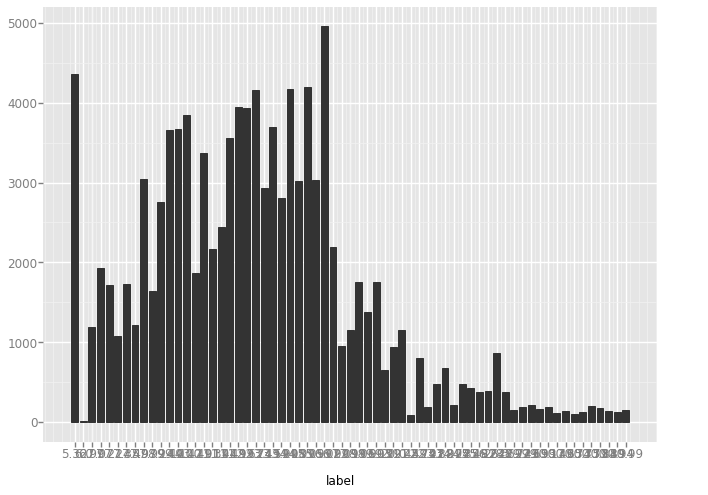

<ggplot: (8739180515117)>

In [24]:
p = ggplot(data_p, aes('label')) + geom_bar()
display(p)

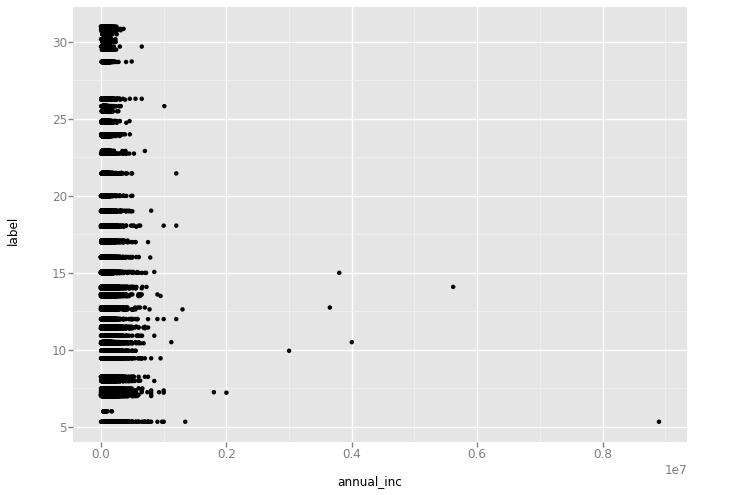

<ggplot: (8739193898525)>

In [25]:
p = ggplot(data_p, aes('annual_inc', 'label')) + geom_point()
display(p)

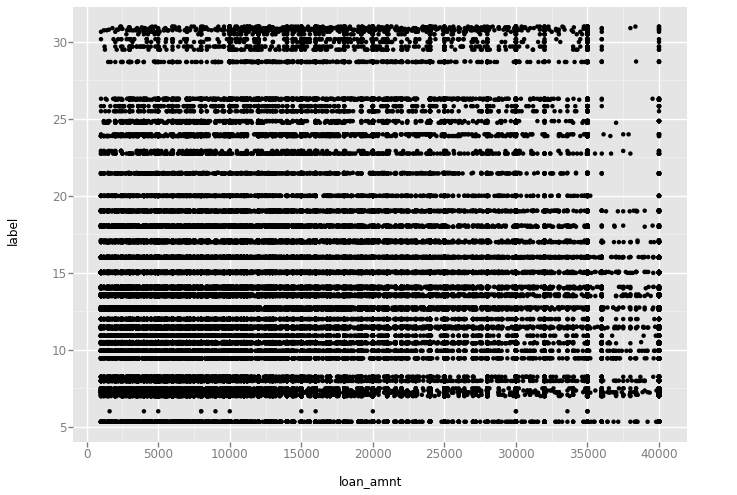

<ggplot: (8739182932841)>

In [26]:
p = ggplot(data_p, aes('loan_amnt', 'label')) + geom_point()
display(p)

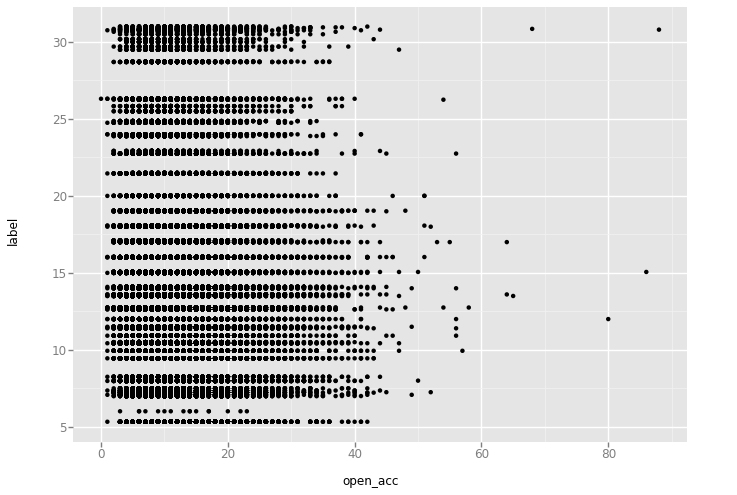

<ggplot: (8739193577913)>

In [27]:
p = ggplot(data_p, aes('open_acc', 'label')) + geom_point()
display(p)

## 3. DATA PREPARATION

## StringIndexer & OneHotEncoder

In algorithms like Linear Regression Analysis or Logistic Regression, categorical variables have to be transformed into numerical variables.

In general, there are two ways to do this:
1. Category Indexing using `StringIndexer`: This is basically assigning a numeric value to each category from {0, 1, 2, ... numCategories-1}. This produces an implicit ordering among the categories, and is more suitable for ordinal variables (e.g., Not Satisfied: 0, Neutral: 1, Satisfied: 2)
2. One-Hot Encoding using `OneHotEncoder`: This converts categories into binary vectors with at most one nonzero value (eg: (Blue: [1,0]), (Green:[0,1]), (Red:[0,0])

#### Please note: If you want One-Hot Encoding, first use Category Indexing and then apply One-Hot Encoding

In [28]:
# Import the functions OneHotEncoder and StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [29]:
stringIndexer = StringIndexer(inputCol="term", outputCol = "termIndex")
model = stringIndexer.fit(data_redu)
data_redu = model.transform(data_redu)

In [30]:
encoder = OneHotEncoder (inputCol="termIndex", outputCol="termVec")
data_redu = encoder.transform(data_redu)

In [31]:
stringIndexer = StringIndexer(inputCol="emp_length", outputCol = "emp_lengthIndex")
model = stringIndexer.fit(data_redu)
data_redu = model.transform(data_redu)

In [32]:
encoder = OneHotEncoder (inputCol="emp_lengthIndex", outputCol="emp_lengthVec")
data_redu = encoder.transform(data_redu)

In [33]:
stringIndexer = StringIndexer(inputCol="home_ownership", outputCol = "home_ownershipIndex")
model = stringIndexer.fit(data_redu)
data_redu = model.transform(data_redu)

In [34]:
encoder = OneHotEncoder (inputCol="home_ownershipIndex", outputCol="home_ownershipVec")
data_redu = encoder.transform(data_redu)

In [35]:
stringIndexer = StringIndexer(inputCol="verification_status", outputCol = "verification_statusIndex")
model = stringIndexer.fit(data_redu)
data_redu = model.transform(data_redu)

In [36]:
encoder = OneHotEncoder (inputCol="verification_statusIndex", outputCol="verification_statusVec")
data_redu = encoder.transform(data_redu)

In [37]:
stringIndexer = StringIndexer(inputCol="purpose", outputCol = "purposeIndex")
model = stringIndexer.fit(data_redu)
data_redu = model.transform(data_redu)

In [38]:
encoder = OneHotEncoder (inputCol="purposeIndex", outputCol="purposeVec")
data_redu = encoder.transform(data_redu)

## VectorAssembler

`VectorAssembler` is a transformer that combines a given list of columns into a single vector column.

It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like Logistic Regression, Linear Regression or Decision Trees. 

In [39]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [40]:
assembler = VectorAssembler(
    inputCols = ["loan_amnt","annual_inc", "open_acc", "termVec", "emp_lengthVec", "home_ownershipVec","verification_statusVec", "purposeVec"],
    outputCol = "features")

In [41]:
output = assembler.transform(data_redu)

In [42]:
print type(output)

<class 'pyspark.sql.dataframe.DataFrame'>


In [43]:
output.toPandas().head(4)

,label,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,open_acc,termIndex,termVec,emp_lengthIndex,emp_lengthVec,home_ownershipIndex,home_ownershipVec,verification_statusIndex,verification_statusVec,purposeIndex,purposeVec,features
0,12.62,2300,36 months,n/a,OWN,10000.0,Not Verified,credit_card,4,0.0,(1.0),5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2300.0, 10000.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0..."
1,12.62,16000,60 months,10+ years,MORTGAGE,94000.0,Not Verified,debt_consolidation,9,1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(16000.0, 94000.0, 9.0, 0.0, 1.0, 0.0, 0.0, 0...."
2,9.44,20400,36 months,10+ years,RENT,44000.0,Source Verified,car,15,0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(20400.0, 44000.0, 15.0, 1.0, 1.0, 0.0, 0.0, 0..."
3,11.99,13000,36 months,10+ years,MORTGAGE,85000.0,Source Verified,debt_consolidation,5,0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(13000.0, 85000.0, 5.0, 1.0, 1.0, 0.0, 0.0, 0...."


In [44]:
output.select("features","label").show(5, truncate = False)

+--------------------------------------------------------------------+-----+
|features                                                            |label|
+--------------------------------------------------------------------+-----+
|(33,[0,1,2,3,9,17,20,22],[2300.0,10000.0,4.0,1.0,1.0,1.0,1.0,1.0])  |12.62|
|(33,[0,1,2,4,15,20,21],[16000.0,94000.0,9.0,1.0,1.0,1.0,1.0])       |12.62|
|(33,[0,1,2,3,4,16,19,27],[20400.0,44000.0,15.0,1.0,1.0,1.0,1.0,1.0])|9.44 |
|(33,[0,1,2,3,4,15,19,21],[13000.0,85000.0,5.0,1.0,1.0,1.0,1.0,1.0]) |11.99|
|(33,[0,1,2,3,13,15,20,23],[6025.0,46350.0,11.0,1.0,1.0,1.0,1.0,1.0])|15.05|
+--------------------------------------------------------------------+-----+
only showing top 5 rows



## Feature Scaling

Feature scaling is a method used to standardize the range of independent variables or features of data. 

In [45]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import *

In [46]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [47]:
scalerModel = scaler.fit(output)

In [48]:
scaledData = scalerModel.transform(output)

In [49]:
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features", "scaledFeatures").show()

Features scaled to range: [0.000000, 1.000000]
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|(33,[0,1,2,3,9,17...|[0.03333333333333...|
|(33,[0,1,2,4,15,2...|[0.38461538461538...|
|(33,[0,1,2,3,4,16...|[0.49743589743589...|
|(33,[0,1,2,3,4,15...|[0.30769230769230...|
|(33,[0,1,2,3,13,1...|[0.12884615384615...|
|(33,[0,1,2,3,4,15...|[0.28205128205128...|
|(33,[0,1,2,12,16,...|[0.28205128205128...|
|(33,[0,1,2,3,13,1...|[0.12820512820512...|
|(33,[0,1,2,3,12,1...|[0.27115384615384...|
|(33,[0,1,2,4,15,2...|[0.49743589743589...|
|(33,[0,1,2,3,4,15...|[0.16666666666666...|
|(33,[0,1,2,3,5,16...|[0.12307692307692...|
|(33,[0,1,2,3,5,16...|[0.02564102564102...|
|(33,[0,1,2,8,15,2...|[0.46025641025641...|
|(33,[0,1,2,4,16,1...|[0.61538461538461...|
|(33,[0,1,2,3,9,15...|[0.48717948717948...|
|(33,[0,1,2,3,7,15...|[0.35897435897435...|
|(33,[0,1,2,3,6,16...|[0.48717948717948...|
|(33,[0,1,2,3,13,1...|[0.2307

In [50]:
scaledData = scaledData.drop('features')

In [51]:
scaledData = scaledData.select(col("scaledFeatures").alias("features"), col("label").alias("label"))

In [52]:
scaledData.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.03333333333333...|12.62|
|[0.38461538461538...|12.62|
|[0.49743589743589...| 9.44|
|[0.30769230769230...|11.99|
|[0.12884615384615...|15.05|
+--------------------+-----+
only showing top 5 rows



### Split the dataset in training and test-dataset!

In [53]:
# Randomly split data into training and test sets. 
# Set seed for reproducibility
(trainingData, testData) = scaledData.randomSplit([0.7,0.3], seed = 111)

In [54]:
print trainingData.count()
print testData.count()

73828
31623


# 4. Modelling

## Model 1 - Multivariate Regression model

In [55]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

In [56]:
# Define LinearRegression algorithm
mlr = LinearRegression()

In [57]:
# Fit base model
modelA = mlr.fit(trainingData, {mlr.regParam:50.0})

In [58]:
print(modelA.intercept)
print(modelA.coefficients)

13.5811244031
[0.24499542104719482,-6.780048154732018,-0.026368987434206115,-0.3687667855278003,-0.025940025088292608,0.010824278651662292,0.008672375949116115,0.02160640584522289,0.01961501934468507,0.0244418367756219,0.017103308508991374,-0.004216642336288721,0.0004285675601512751,-0.013837266967171073,-0.011582129157995467,-0.0749888247439985,0.0708362336971533,0.019469864400112686,-0.15267381322102846,0.04897868865260387,-0.23400438586455904,0.08192876567693302,-0.12401907521485761,-0.07385919270669215,0.09925925285006724,-0.034704392273860046,-0.03683584596122554,-0.09877796405228091,-0.06423440832782867,0.11336545132369018,0.06949166338709992,0.23960343076816318,-0.010778253610731042]


In [59]:
predictionsA = modelA.transform(testData)
predictionsA.show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.0,0.0011235955...|16.02|13.380148536615462|
|[0.0,0.0013483146...|23.88|13.155511446083938|
|[0.0,0.0013483146...|12.62|13.217428255787391|
|[0.0,0.0013483146...|17.99| 13.11058466230009|
|[0.0,0.0013483146...|10.91|13.443735515776375|
+--------------------+-----+------------------+
only showing top 5 rows



### Evaluation of Linear Model 1

#### Root Mean Squared Error

In [60]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse")

RMSE = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

ModelA: Root Mean Squared Error = 5.06417229798


#### Coefficient of Determination - R2

In [61]:
modelA.summary.r2

0.04277775861794775

## Model 2- Polynomial Regression model

In [62]:
from pyspark.ml.feature import PolynomialExpansion

In [63]:
polyExpansion = PolynomialExpansion(degree=2, inputCol="features", outputCol="features_poly")

In [64]:
polyDF = polyExpansion.transform(scaledData)

In [65]:
(trainingData1, testData1) = polyDF.randomSplit([0.7,0.3], seed = 111)

In [66]:
mlr = LinearRegression()

In [67]:
# Fit a model
model_poly = mlr.fit(trainingData1)

In [68]:
print(model_poly.intercept)
print(model_poly.coefficients)

14.401578318
[0.5989846053773497,-90.62459139766054,1.0191319265627536,-4.065375537719474,-0.14124726520508374,0.07605638880672541,-0.17205780784192315,0.20046742692143987,0.18962293305486583,0.1420721421949384,0.17008050073908879,-0.01776489714707565,0.00643986463368061,-0.06171534539326423,-0.14922927826483132,3.0586345034088134,4.104929569954268,3.941448418625489,2.563592505554157,-0.9634697538303634,-3.0297613633668323,0.4179572862415915,-0.715974857171195,0.09954765754612831,1.3769288704371025,0.15806241548298872,0.18689667449757516,-0.140874528111397,0.06997901251323167,1.6649453699877539,0.29751576464762447,2.145667234288633,-0.028835093448002183]


In [69]:
# Make predictions
predictions_poly_A = model_poly.transform(testData1)
predictions_poly_A.show(5)

+--------------------+-----+--------------------+------------------+
|            features|label|       features_poly|        prediction|
+--------------------+-----+--------------------+------------------+
|[0.0,0.0011235955...|16.02|[0.0,0.0,0.001123...|14.968822662836548|
|[0.0,0.0013483146...|23.88|[0.0,0.0,0.001348...|12.870933031630708|
|[0.0,0.0013483146...|12.62|[0.0,0.0,0.001348...|12.875444390494687|
|[0.0,0.0013483146...|17.99|[0.0,0.0,0.001348...| 12.71418665561787|
|[0.0,0.0013483146...|10.91|[0.0,0.0,0.001348...|14.990283594963245|
+--------------------+-----+--------------------+------------------+
only showing top 5 rows



### Evaluation of Polynomial Model 2

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")

RMSE = evaluator.evaluate(predictions_poly_A)
print("Model_poly: Root Mean Squared Error = " + str(RMSE))

Model_poly: Root Mean Squared Error = 4.56501344561


In [71]:
model_poly.summary.r2

0.222635845598659

## Model 3 - Tuning Model 2 

In [72]:
##=====build cross valiation model======

# estimator
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

# parameter grid
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0, 0.5, 1]).\
    addGrid(lr.elasticNetParam, [0, 0.5, 1]).\
    build()
    
# evaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2')

# cross-validation model
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [ ]:
cv_model = cv.fit(trainingData1)

In [ ]:
pred_training_cv = cv_model.transform(trainingData1)
pred_test_cv = cv_model.transform(testData1)

In [ ]:
# performance on training data
evaluator.evaluate(pred_training_cv)

# performance on test data
evaluator.evaluate(pred_test_cv)

In [ ]:
print('best regParam: ' + str(cv_model.bestModel._java_obj.getRegParam()) + "\n" +
     'best ElasticNetParam:' + str(cv_model.bestModel._java_obj.getElasticNetParam()))

#### Based on the above parameter, tune the polynomial model to obtain optimum results for the model

In [ ]:
# Fit a model
model_final = mlr.fit(trainingData1, {mlr.regParam:0.0})

In [ ]:
print(model_final.intercept)
print(model_final.coefficients)

In [ ]:
# Make predictions
predictions_final = model_poly.transform(testData1)
predictions_final.show(5)

#### Evaluation of the tuned Polynomial Model 3

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")

RMSE = evaluator.evaluate(predictions_poly_A)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

In [ ]:
model_final.summary.r2

# 4. Evaluation

Upon performing modelling on different training set, we have the RMSE and R2 values for all our models.
Lower the RMSE value, better the model.
Higher the value of R2, better the model.

Looking at our models, Polynomial Regression model and Tuned Polinomial Regression model give us the same RMSE and R2 values.

For the simplicity of the model, we use Polynomial model as our final model.

### Compare training- and test-fit for the best model (model 2)

Make predictions based on the training dataset and testing set

In [ ]:
# Model 
predictions_trainpoly_A = modelA.transform(trainingData1)
predictions_testpoly_A = modelA.transform(testData1)

Calculate and Compare R2 of both models

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="r2")

In [ ]:
# Model_poly
r2_trainingp_A = evaluator.evaluate(predictions_trainpoly_A)
r2_testp_A = evaluator.evaluate(predictions_testpoly_A)

In [ ]:
print r2_trainingp_A *100
print r2_testp_A *100
print (r2_trainingp_A - r2_testp_A) * 100

## Inspect the main assumption of regression models - Normal Distribution of Error

In [ ]:
from ggplot import *
from seaborn import *
from pyspark.sql.functions import *

In [ ]:
## Calculate the residuals
# In dataset: labels (observed values) and predicted values (based on model) --> difference of both: residual
#predictionsA.show(5)
#residuals_A = predictionsA.select(col('label') - col('prediction') )
#residuals_A.show(5)
predictions_poly_A = predictions_poly_A.withColumn("residuals", col('label') - col('prediction'))
predictions_poly_A.show(5)

In [ ]:
print type(predictions_poly_A)
data.createOrReplaceTempView("predictionsA")

In [ ]:
## Convert Spark DataFrame into pandas
predictions_poly_A_pandas = predictions_poly_A.toPandas()
print type(predictions_poly_A_pandas)

In [ ]:
from seaborn import *

In [ ]:
distplot(predictions_poly_A_pandas['residuals'], rug = True)

# 5. Deployment 

Deployment is where machine learning pays off.

In this final phase of the Cross-Industry Standard Process for Data Mining (CRISP-DM) process, it doesn't matter how brilliant the discoveries may be, or how perfectly your models fit the data, if we don't actually use those things to improve the way that you do business.

#### So final deployment of the model has to be carried out by implementing the tool online in the Lending club website.